In [1]:
adsorbate = 'OH'
model_name = 'model0'

# Fitting a model

## Get the training data

In [2]:
import numpy as np
from gaspy import gasdb

docs = gasdb.get_adsorption_docs(adsorbates=[adsorbate])
energies_dft = np.array([doc['energy'] for doc in docs])

Now pulling adsorption documents...


2882it [00:00, 81296.00it/s]


## Processing the features
First we get the pipelines/classes that can fingerprint sites for us

In [3]:
from gaspy_regress import fingerprinters

inner_fingerprinter = fingerprinters.InnerShellFingerprinter(adsorbate)
outer_fingerprinter = fingerprinters.OuterShellFingerprinter(adsorbate)
fingerprinter = fingerprinters.StackedFingerprinter(inner_fingerprinter, outer_fingerprinter)

Now pulling adsorption documents...


2882it [00:00, 83424.67it/s]


Now pulling catalog documents...


2591434it [03:33, 12118.43it/s]
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jovyan/GASpy/GASpy_regressions/gaspy_regress/fingerprinters.py:189: RuntimeWarning: We do not have any energy data for Mn, so we set its median adsorption energy as the median of all energies
  warnings.warn(message, RuntimeWarning)
/home/jovyan/GASpy/GASpy_regressions/gaspy_regress/fingerprinters.py:189: RuntimeWarning: We do not have any energy data for Cr, so we set its median adsorption energy as the median of all energies
  warnings.warn(message, RuntimeWarning)
/home/jovyan/GASpy/GASpy_regressions/gaspy_regress/fingerprinters.py:189: RuntimeWarning: We do not have any energy data for K, so we set its median adsorption energy as the median of all energies
 

Now pulling adsorption documents...


2882it [00:00, 88274.05it/s]


Now pulling catalog documents...


2591434it [03:27, 12484.55it/s]


Then we do some preprocessing to the fingerprints/features, such as scaling and PCA.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

fps = fingerprinter.fingerprint_docs(docs)

scaler = StandardScaler()
scaled_fps = scaler.fit_transform(fps)

reducer = PCA()
reduced_fps = reducer.fit_transform(scaled_fps)

# Just an alias to improve readability later on
features = reduced_fps

Now wrap the fingerprinting/preprocessing pipeline into a small function.

In [5]:
def fingerprint_docs(docs):
    fps = fingerprinter.fingerprint_docs(docs)
    scaled_fps = scaler.transform(fps)
    reduced_fps = reducer.transform(scaled_fps)
    return reduced_fps

Let's make sure that our wrapper is working correctly.

In [6]:
import numpy.testing as npt

features_from_wrapper = fingerprint_docs(docs)
npt.assert_allclose(features, features_from_wrapper, rtol=1e-7, atol=1e-5)

## Performing the regression

In [7]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(
                     generations=1,
                     population_size=16,
                     offspring_size=16,
                     verbosity=2,
                     #random_state=42,
                     scoring='neg_median_absolute_error',
                     n_jobs=16,
                    )
energies_ml = tpot.fit_predict(features, energies_dft)

Generation 1 - Current best internal CV score: -0.22319451365789372

Best pipeline: RandomForestRegressor(GradientBoostingRegressor(input_matrix, alpha=0.85, learning_rate=0.1, loss=huber, max_depth=10, max_features=0.95, min_samples_leaf=20, min_samples_split=2, n_estimators=100, subsample=0.5), bootstrap=False, max_features=0.25, min_samples_leaf=3, min_samples_split=10, n_estimators=100)


# Visualizing the regression
Note that we visualize the fit on only our training set, so the fit will look much better than it actually is. People normally combat this by doing train/test splits, but our workflow is online and iterative, thereby invalidating the normal train/test splitting workflow.

A proper method to verify quality of our fit is to do an [evaluation on a rolling forecasting origin](https://robjhyndman.com/hyndsight/tscv/), but that takes a lot of computational resources to perform retroactively. So we dedicate that for an entirely different notebook

What these plots tell us, at least, is that we did not perform the fitting horribly incorrectly. These are mainly gut-checks to verify that we don't have an obvious bug in our pipeline.

Put the data into a Pandas dataframe so that we can work with it a bit easier

In [8]:
import pandas as pd

df = pd.DataFrame({'documents': docs,
                   'DFT energies [eV]': energies_dft,
                   'ML energies [eV]': energies_ml,
                   'Residuals [eV]': energies_ml - energies_dft})

## Parity plot

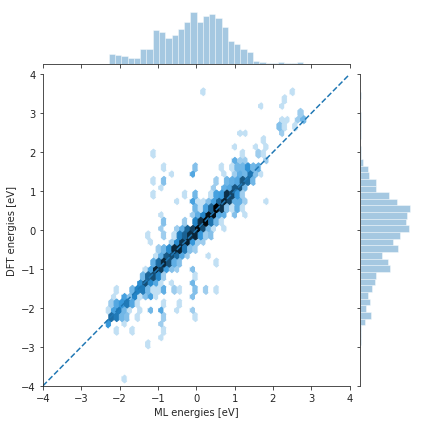

In [13]:
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline

# Make the joint plot
plot_lims = (-4, 4)
grid = sns.jointplot('ML energies [eV]', 'DFT energies [eV]', data=df,
                     kind='hex', bins='log')
_ = grid.ax_joint.set_xlim(plot_lims)
_ = grid.ax_joint.set_ylim(plot_lims)

# Draw a parity line
_ = grid.ax_joint.plot(plot_lims, plot_lims, '--')

## Distribution of residuals

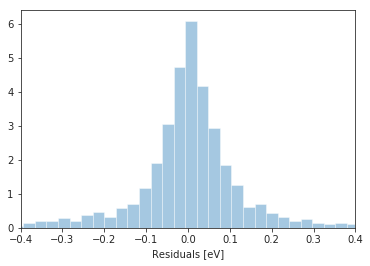

In [10]:
ax = sns.distplot(df['Residuals [eV]'], bins=200, kde=False, norm_hist=True)
_ = ax.set_xlim((-0.4, 0.4))

# Saving the predictions

Get the catalog sites that we'll be making ML predictions for.

In [11]:
catalog_docs = gasdb.get_catalog_docs(rebuild_cache=True)

Now pulling catalog documents...


2591434it [03:20, 12944.58it/s]


Make the ML predictions on the catalog

In [12]:
fingerprints = fingerprint_docs(catalog_docs)
ml_predictions = tpot.predict(fingerprints)

Save the ML predictions

In [13]:
import datetime
from pymongo import UpdateOne

# The current date will be a Mongo key.
# Because it's a key, it'll need to be a string. Make that string here.
now = datetime.datetime.now()
year = str(now.year)
month = str(now.month)
day = str(now.day)
current_date = '_'.join([year, month, day])

# We'll be using pymongo's `bulk_write`, which takes
# a list of commands. We'll be making a list of `UpdateOne` commands.
mongo_commands = []
for doc, ml_energy in zip(catalog_docs, ml_predictions):
    mongo_id = doc['mongo_id']
    energy_location = 'predictions.adsorption_energy.%s.%s.%s.energy' \
                      % (adsorbate, model_name, current_date)
    command = UpdateOne({'_id': mongo_id},
                        {'$set': {energy_location: ml_energy,
                                  'mtime': datetime.datetime.utcnow()}})
    mongo_commands.append(command)

# Write the results
with gasdb.get_mongo_collection('relaxed_bulk_catalog') as collection:
    mongo_result = collection.bulk_write(mongo_commands, ordered=False)